## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.utils import algorithm_globals

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

# Importing Matplotlib & Numpy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import default_rng

### 1-2. Setting of the main hyper-parameters of the model

In [2]:
BATCH_SIZE = 100
N_BITS = 4
# N_params = 12
# N_SHOTS = 1024
# iteration = 100
N_EPOCHS = 30
# N_LAYERS = 1    # Number of random layers

# SAVE_PATH = "aeqis/" # Data saving folder
seed = 23
np.random.seed(seed)        # Seed for NumPy random number generator
rng = default_rng(seed)
algorithm_globals.random_seed = seed

isReal = False # 'True' for real device or 'False' for simulator
use_gpu = False

### 1-3. Data loading

In [3]:
# Code fot data loading
input_data = np.random.rand(N_BITS) * 2
input_data -= 1
print(input_data)

[ 0.03459577  0.89392521  0.53091952 -0.43520831]


## 2. Construct Quantum Circuit

### 2-1. Initializing

In [4]:
# Setup a base quantum circuit for our experiments
"""
reg_d is used to embed the sequential data, one element at each time step
reg_h is used to store information about the history of all previous elements
"""
qr = QuantumRegister(2*N_BITS)
reg_d = qr[0:N_BITS]
reg_h = qr[N_BITS:2*N_BITS]

# Output at each time step
cr = ClassicalRegister(N_BITS)

# Adjustable parameters to be optimized in the learning process
single_rotation_params = np.random.rand(N_BITS,3) * 2 * np.pi
controlled_rotation_params = np.random.rand(N_BITS) * 2 * np.pi

# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(qr, cr)

In [5]:
initial_state = initialize_circuit()

# initial_state.draw(output="mpl")
print(single_rotation_params)
print(controlled_rotation_params)

[[1.38886898 4.31166052 1.05016659]
 [2.46578874 3.88333743 2.58823312]
 [0.01548731 5.55453802 5.56028937]
 [1.88752975 3.70445211 6.14763762]]
[5.30988109 0.40888104 1.85193409 1.80914545]


### 2-2. Angle Encoding

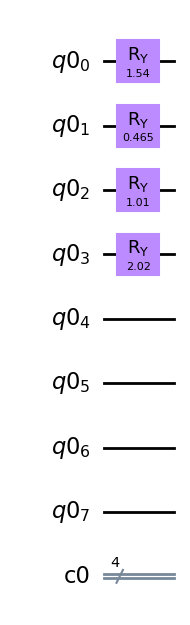

In [6]:
def encode_angle(qc, input_data, qr, n_qubits):
    # input_data /= np.max(np.abs(input_data),axis=0)
    encoded_angle = np.arccos(input_data)
    for i in range(n_qubits):
        qc.ry(encoded_angle[i], qr[i])
    return qc

# The circuit encoding our qubit
encoding_circuit = encode_angle(initialize_circuit(), input_data, reg_d, N_BITS)
encoding_circuit.draw("mpl")

### 2-3. Arbitrary single-qubit gates

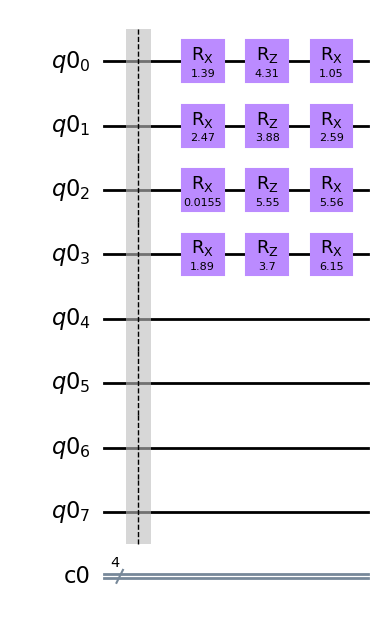

In [7]:
def apply_single_qubit_gates(qc, qr, params, n_qubits):
    qc.barrier()
    for i in range(n_qubits):
        qc.rx(params[i][0], qr[i])
        qc.rz(params[i][1], qr[i])
        qc.rx(params[i][2], qr[i])
    return qc

single_rotation = apply_single_qubit_gates(initialize_circuit(), reg_d, single_rotation_params, N_BITS)
single_rotation.draw("mpl")

### 2-4. Rzz gates

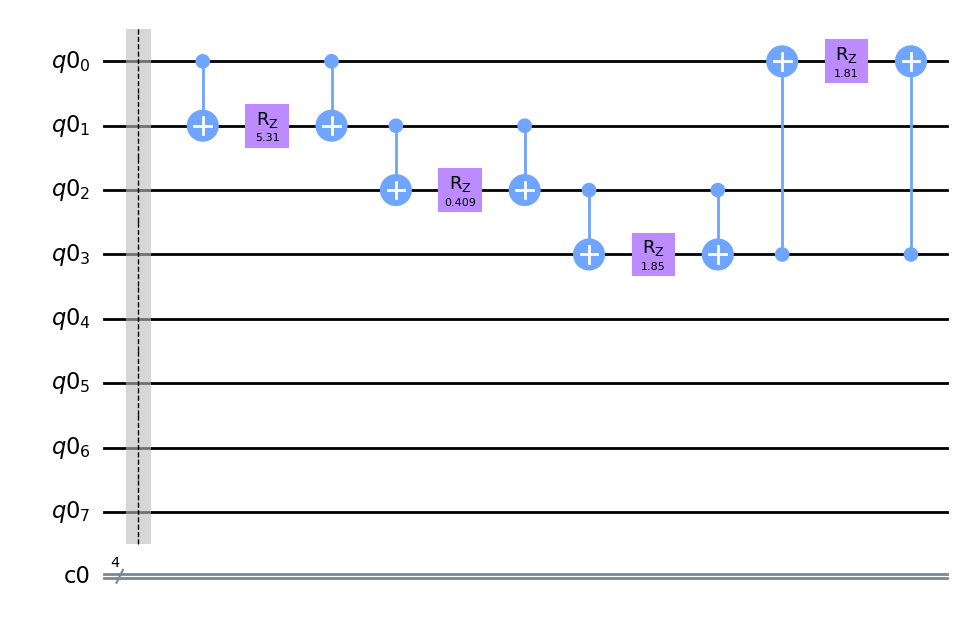

In [8]:
def apply_two_qubit_gates(qc, qr, params, n_qubits):
    qc.barrier()
    for i in range(-n_qubits, 0):
        qc.cx(qr[i], qr[i+1])
        qc.rz(params[i], qr[i+1])
        qc.cx(qr[i], qr[i+1])
    return qc

controlled_rotation = apply_two_qubit_gates(initialize_circuit(), reg_d, controlled_rotation_params, N_BITS)
controlled_rotation.draw("mpl")

### 2-5. Ansatz circuit

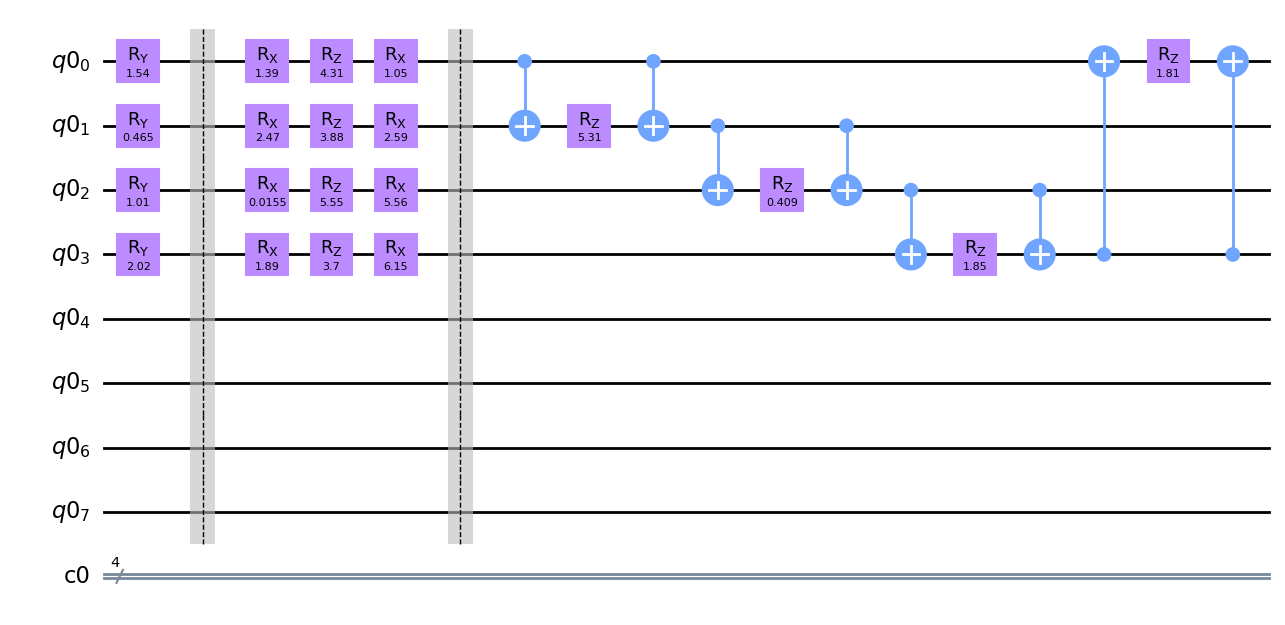

In [9]:
ansatz_circuit = initial_state.compose(encoding_circuit).compose(single_rotation).compose(controlled_rotation)
ansatz_circuit.draw("mpl")